## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

### Обзор данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Загрузка библиотек 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as catb
import lightgbm as lgbm
import xgboost as xgb

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'catboost'

### Обзор датасета

In [2]:
train = pd.read_csv("course_project_train.csv")
test = pd.read_csv("course_project_test.csv")

In [3]:
train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [5]:
train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [6]:
test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [8]:
test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>,
        <AxesSubplot:title={'center':'Years of Credit History'}>],
       [<AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>,
        <AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>],
       [<AxesSubplot:title={'center':'Current Loan Amount'}>,
        <AxesSubplot:title={'center':'Current Credit Balance'}>,
        <AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>],
       [<AxesSubplot:title={'center':'Credit Default'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

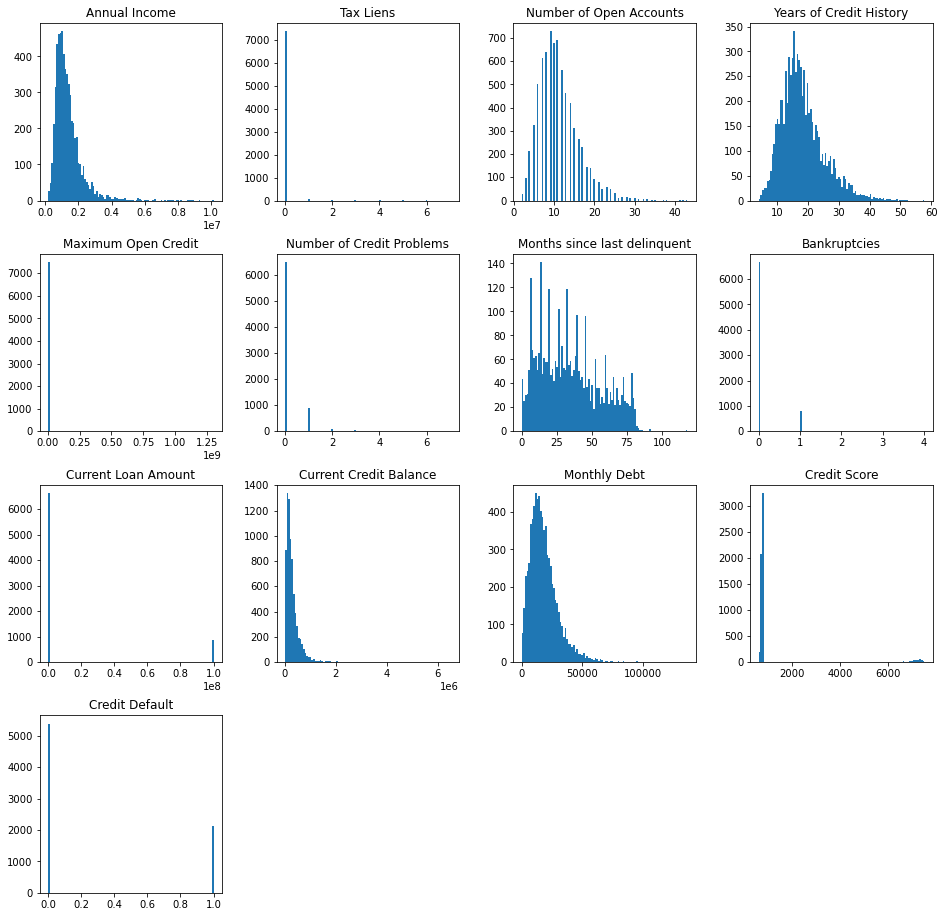

In [9]:
train.hist(figsize=(16,16), bins=100, grid=False)

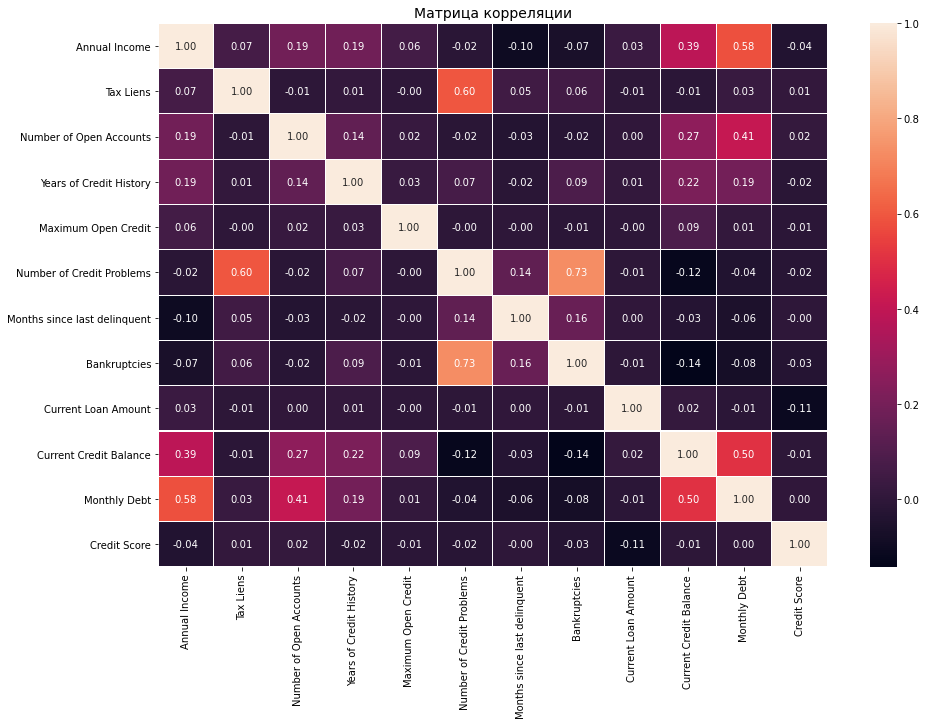

In [10]:
df_corr = train.drop(['Credit Default'], axis=1).corr()
f, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(df_corr, annot=True, linewidths=0.1, fmt='.2f', ax=ax)
            
plt.title('Матрица корреляции', size=14)
plt.show()

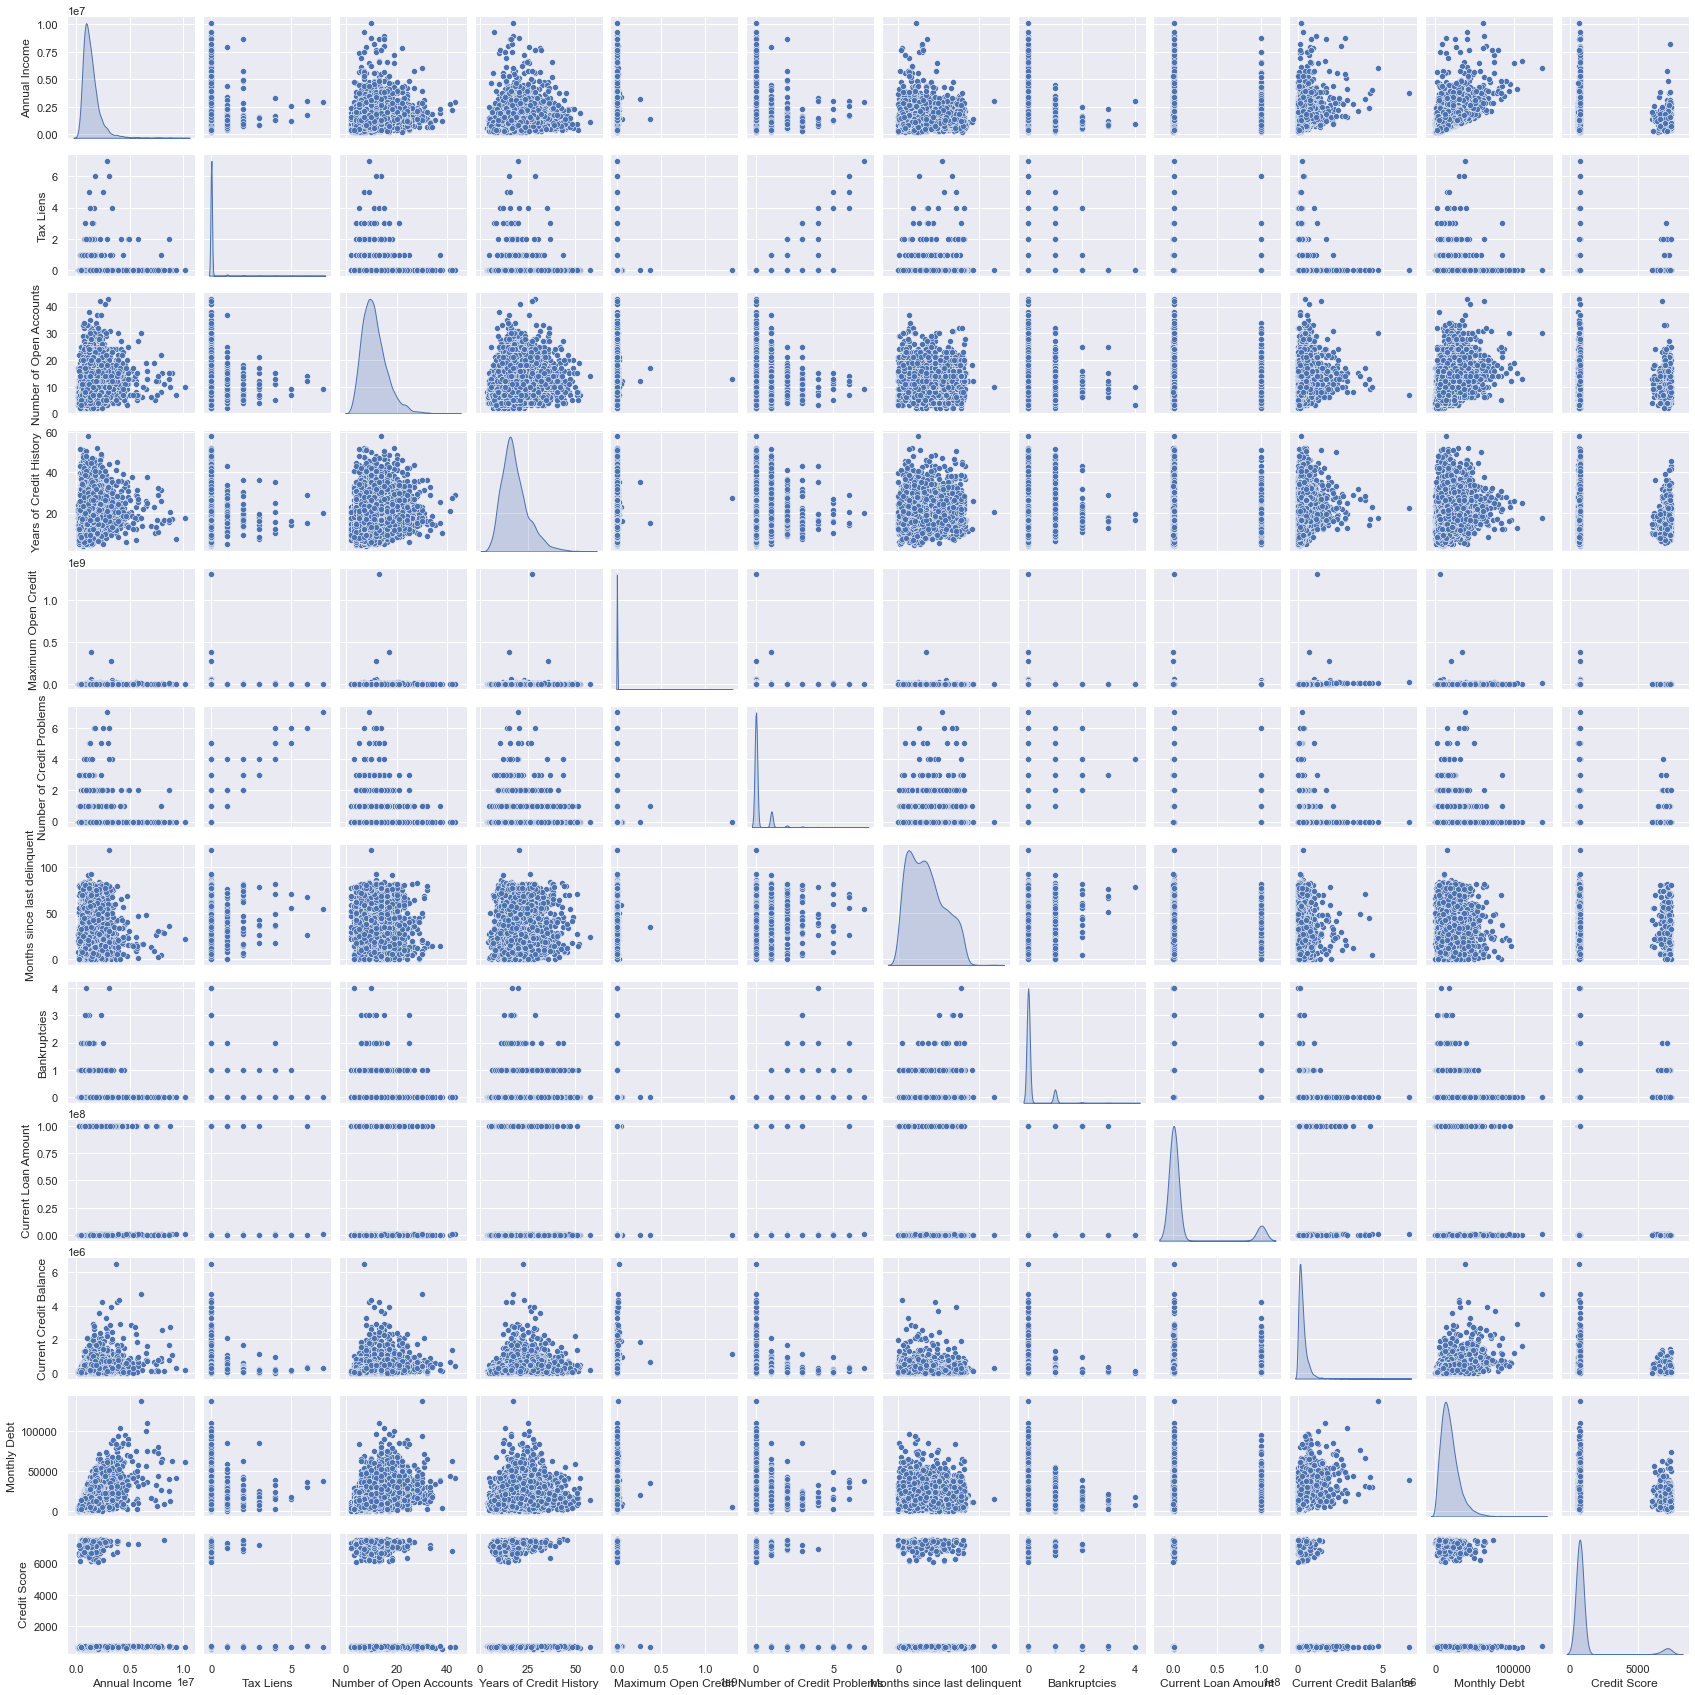

In [11]:
sns.set()
columns = [
    "Annual Income",
    "Tax Liens",
    "Number of Open Accounts",
    "Years of Credit History",
    "Maximum Open Credit",
    "Number of Credit Problems",
    "Months since last delinquent",
    "Bankruptcies",
    "Current Loan Amount",
    "Current Credit Balance",
    "Monthly Debt",
    "Credit Score"
]
sns.pairplot(train[columns], height=2, kind="scatter", diag_kind="kde")
plt.show()

### Обработка пропусков

In [12]:
train['Id'] = np.arange(0, len(train))
test['Id'] = np.arange(7500, 7500 + len(test))

In [13]:
def print_categorical(data):
    for cat_colname in data.columns:
        if len(data[cat_colname].unique()) < 20:
            print(str(cat_colname) + '\n\n' + str(data[cat_colname].unique()) + '\n\n')
            print(data.groupby(cat_colname)[cat_colname].count())
            print('*' * 100 + '\n')

In [14]:
print_categorical(train)

Home Ownership

['Own Home' 'Home Mortgage' 'Rent' 'Have Mortgage']


Home Ownership
Have Mortgage      12
Home Mortgage    3637
Own Home          647
Rent             3204
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

[nan '10+ years' '8 years' '6 years' '7 years' '5 years' '1 year'
 '< 1 year' '4 years' '3 years' '2 years' '9 years']


Years in current job
1 year        504
10+ years    2332
2 years       705
3 years       620
4 years       469
5 years       516
6 years       426
7 years       396
8 years       339
9 years       259
< 1 year      563
Name: Years in current job, dtype: int64
****************************************************************************************************

Tax Liens

[0. 3. 1. 2. 4. 6. 5. 7.]


Tax Liens
0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64
**********

In [15]:
map_home = {'Have Mortgage': 2, 'Home Mortgage': 2, 'Own Home': 3, 'Rent': 1}
train["Home Ownership"] = train["Home Ownership"].map(map_home)
test["Home Ownership"] = test["Home Ownership"].map(map_home)

In [16]:
map_year = {'< 1 year': 0.5, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5,
          '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}
train["Years in current job"] = train["Years in current job"].map(map_year)
test["Years in current job"] = test["Years in current job"].map(map_year)

In [17]:
train["Years in current job"] = train["Years in current job"].fillna(0)
test["Years in current job"] = test["Years in current job"].fillna(0)

In [18]:
train.loc[train["Term"] == "Long Term", "Term"] = 1
train.loc[train["Term"] == "Short Term", "Term"] = 0
test.loc[test["Term"] == "Long Term", "Term"] = 1
test.loc[test["Term"] == "Short Term", "Term"] = 0

In [19]:
train["Term"] = train["Term"].astype(np.int64)
test["Term"] = test["Term"].astype(np.int64)

In [20]:
notnull_income = train.loc[train['Annual Income'].notnull(), :]
dev = notnull_income['Annual Income'].mean() / notnull_income['Monthly Debt'].mean()
train['Annual Income'].fillna(train['Monthly Debt'] * dev, inplace=True)
test['Annual Income'].fillna(test['Monthly Debt'] * dev, inplace=True)

In [21]:
train['Months since last delinquent'].fillna(0, inplace=True)
test['Months since last delinquent'].fillna(0, inplace=True)
train['Bankruptcies'].fillna(0, inplace=True)
test['Bankruptcies'].fillna(0, inplace=True)

In [22]:
map_purpose = {'business loan': 1, 'buy a car': 2, 'buy house': 3, 'debt consolidation': 4, 'educational expenses': 5,
               'home improvements': 6, 'major purchase': 7, 'medical bills': 8, 'moving': 9, 'other': 10,
               'renewable energy': 11, 'small business': 12, 'take a trip': 13, 'vacation': 14, 'wedding': 15}
train["Purpose"] = train["Purpose"].map(map_purpose)
test["Purpose"] = test["Purpose"].map(map_purpose)

In [23]:
train['Credit Score'].fillna(3000, inplace=True)
test['Credit Score'].fillna(3000, inplace=True)

In [24]:
train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Id
0,3,482087.0,0.0,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,4,0,99999999.0,47386.0,7914.0,749.0,0,0
1,3,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,4,1,264968.0,394972.0,18373.0,737.0,1,1
2,2,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,4,0,99999999.0,308389.0,13651.0,742.0,0,2
3,3,805068.0,6.0,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,4,0,121396.0,95855.0,11338.0,694.0,0,3
4,1,776264.0,8.0,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,4,0,125840.0,93309.0,7180.0,719.0,0,4


In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   int64  
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   int64  
 11  Term                          7500 non-null   int64  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [26]:
print_categorical(train)

Home Ownership

[3 2 1]


Home Ownership
1    3204
2    3649
3     647
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

[ 0.  10.   8.   6.   7.   5.   1.   0.5  4.   3.   2.   9. ]


Years in current job
0.0      371
0.5      563
1.0      504
2.0      705
3.0      620
4.0      469
5.0      516
6.0      426
7.0      396
8.0      339
9.0      259
10.0    2332
Name: Years in current job, dtype: int64
****************************************************************************************************

Tax Liens

[0. 3. 1. 2. 4. 6. 5. 7.]


Tax Liens
0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Credit Problems

[1. 0. 3. 2. 6. 4. 5. 7.]


Number of Credit Problems
0.0    6469
1.0     882
2.0 

In [27]:
target = 'Credit Default'

In [28]:
num_features = train.columns.drop(target).drop('Id').tolist()
train[num_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   int64  
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   int64  
 11  Term                          7500 non-null   int64  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [29]:
X = train[num_features]
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [30]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.values.argmax()
    minor_class_name = target_counts.values.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [31]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target)
    
df_balanced[target].value_counts()
X_train = df_balanced.drop(columns=target)
y_train = df_balanced[target]

### Построение моделей

In [32]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [33]:
result_model_score = {}

#### Logistic Regression

In [34]:
model_lr = LogisticRegression(
    solver='liblinear', 
    penalty='l2',
    max_iter=160,
    class_weight='balanced',
    C=2,
)
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_lr
model_score['model_name'] = 'model_lr'

result_model_score['Logistic Regression'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.58      0.64      3771
           1       0.57      0.72      0.64      2958

    accuracy                           0.64      6729
   macro avg       0.65      0.65      0.64      6729
weighted avg       0.66      0.64      0.64      6729

TEST

              precision    recall  f1-score   support

           0       0.83      0.57      0.68      1616
           1       0.39      0.71      0.50       634

    accuracy                           0.61      2250
   macro avg       0.61      0.64      0.59      2250
weighted avg       0.71      0.61      0.63      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               924  692
1               187  447


#### K Nearest Neighbours

In [35]:
model_knn = KNeighborsClassifier(
    weights='uniform',
    p=1,
    n_neighbors=1,
    leaf_size=19,
    algorithm='ball_tree',
    n_jobs=-1,
)
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_knn
model_score['model_name'] = 'model_knn'
result_model_score['K Nearest Neighbours'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3771
           1       1.00      1.00      1.00      2958

    accuracy                           1.00      6729
   macro avg       1.00      1.00      1.00      6729
weighted avg       1.00      1.00      1.00      6729

TEST

              precision    recall  f1-score   support

           0       0.74      0.75      0.75      1616
           1       0.35      0.35      0.35       634

    accuracy                           0.64      2250
   macro avg       0.55      0.55      0.55      2250
weighted avg       0.63      0.64      0.63      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1210  406
1                415  219


#### eXtreme Gradient Boosting - XGBoost

In [36]:
model_xgb = xgb.XGBClassifier(
    subsample=0.7,
    reg_alpha=0.08,
    n_estimators=750,
    min_child_weight=13,
    max_depth=4,
    learning_rate=0.36,
    gamma=1,
    colsample_bytree=0.8,
    colsample=0.5,
    n_jobs=-1,
    random_state=21
)

model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_xgb
model_score['model_name'] = 'model_xgb'
result_model_score['XGBoost'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3771
           1       0.99      1.00      1.00      2958

    accuracy                           1.00      6729
   macro avg       1.00      1.00      1.00      6729
weighted avg       1.00      1.00      1.00      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1616
           1       0.49      0.45      0.47       634

    accuracy                           0.71      2250
   macro avg       0.64      0.63      0.64      2250
weighted avg       0.71      0.71      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1315  301
1                346  288


#### LightGBM

In [37]:
model_lgbm = lgbm.LGBMClassifier(
    subsample=0.4,
    reg_lambda=0.0,
    reg_alpha=0.75,
    num_leaves=40,
    n_estimators=250,
    min_child_weight=0.05,
    max_depth=3,
    learning_rate=0.86,
    is_unbalance=True,
    boosting_type='gbdt',
    n_jobs=-1,
    random_state=21
)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['name'] = 'LightGBM'
model_score['model'] = model_lgbm
model_score['model_name'] = 'model_lgbm'
result_model_score['LightGBM'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3771
           1       0.97      1.00      0.98      2958

    accuracy                           0.99      6729
   macro avg       0.98      0.99      0.99      6729
weighted avg       0.99      0.99      0.99      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.78      0.79      1616
           1       0.47      0.48      0.47       634

    accuracy                           0.70      2250
   macro avg       0.63      0.63      0.63      2250
weighted avg       0.70      0.70      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1263  353
1                327  307


#### CatBoost

In [38]:
model_catb = catb.CatBoostClassifier(
    od_type='IncToDec',
    n_estimators=1250,
    max_depth=3,
    learning_rate=0.66, 
    l2_leaf_reg=5,
    silent=True, 
    random_state=21,
)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_catb
model_score['model_name'] = 'model_catb'
result_model_score['CatBoost'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3771
           1       1.00      1.00      1.00      2958

    accuracy                           1.00      6729
   macro avg       1.00      1.00      1.00      6729
weighted avg       1.00      1.00      1.00      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1616
           1       0.48      0.45      0.47       634

    accuracy                           0.71      2250
   macro avg       0.63      0.63      0.63      2250
weighted avg       0.70      0.71      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1306  310
1                348  286


#### Ada Boost

In [39]:
model_ada = AdaBoostClassifier(
    n_estimators=400,
    learning_rate=0.86,
    algorithm='SAMME.R',
)
model_ada.fit(X_train, y_train)

y_train_pred = model_ada.predict(X_train)
y_test_pred = model_ada.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_ada
model_score['model_name'] = 'model_ada'
result_model_score['Ada Boost'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.83      0.79      3771
           1       0.75      0.65      0.70      2958

    accuracy                           0.75      6729
   macro avg       0.75      0.74      0.75      6729
weighted avg       0.75      0.75      0.75      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.78      0.80      1616
           1       0.49      0.55      0.52       634

    accuracy                           0.72      2250
   macro avg       0.65      0.66      0.66      2250
weighted avg       0.72      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1263  353
1                288  346


#### Support Vector Machine

In [40]:
model_svm = SVC(
    C=0.5, 
    class_weight='balanced', 
    gamma='auto'
)
model_svm.fit(X_train, y_train)

y_train_pred = model_svm.predict(X_train)
y_test_pred = model_svm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_svm
model_score['model_name'] = 'model_svm'
result_model_score['Support Vector Machine'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3771
           1       1.00      1.00      1.00      2958

    accuracy                           1.00      6729
   macro avg       1.00      1.00      1.00      6729
weighted avg       1.00      1.00      1.00      6729

TEST

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1616
           1       0.00      0.00      0.00       634

    accuracy                           0.72      2250
   macro avg       0.36      0.50      0.42      2250
weighted avg       0.52      0.72      0.60      2250

CONFUSION MATRIX

col_0              0
Credit Default      
0               1616
1                634


#### Perceptron

In [41]:
model_pctr = Perceptron(class_weight='balanced')
model_pctr = model_pctr.fit(X_train, y_train)

y_train_pred = model_pctr.predict(X_train)
y_test_pred = model_pctr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_pctr
model_score['model_name'] = 'model_pctr'
result_model_score['Perceptron'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.66      0.47      0.55      3771
           1       0.51      0.69      0.59      2958

    accuracy                           0.57      6729
   macro avg       0.59      0.58      0.57      6729
weighted avg       0.59      0.57      0.57      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.46      0.58      1616
           1       0.34      0.71      0.46       634

    accuracy                           0.53      2250
   macro avg       0.57      0.59      0.52      2250
weighted avg       0.67      0.53      0.55      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               739  877
1               182  452


#### Naive Bayes

In [42]:
model_bay = GaussianNB()
model_bay = model_bay.fit(X_train, y_train)

y_train_pred = model_bay.predict(X_train)
y_test_pred = model_bay.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_bay
model_score['model_name'] = 'model_bay'
result_model_score['Naive Bayes'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.18      0.31      3771
           1       0.49      0.99      0.65      2958

    accuracy                           0.54      6729
   macro avg       0.72      0.59      0.48      6729
weighted avg       0.75      0.54      0.46      6729

TEST

              precision    recall  f1-score   support

           0       0.98      0.19      0.31      1616
           1       0.32      0.99      0.49       634

    accuracy                           0.41      2250
   macro avg       0.65      0.59      0.40      2250
weighted avg       0.79      0.41      0.36      2250

CONFUSION MATRIX

col_0             0     1
Credit Default           
0               303  1313
1                 7   627


#### Extremely Randomised Trees

In [43]:
model_ext = ExtraTreesClassifier(
    max_features='auto',
    bootstrap=True,
    oob_score=True,
    n_estimators=700,
    max_depth=7,
    min_samples_split=0.2,
    class_weight='balanced_subsample',
    )
model_ext = model_ext.fit(X_train, y_train)

y_train_pred = model_ext.predict(X_train)
y_test_pred = model_ext.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_ext
model_score['model_name'] = 'model_ext'
result_model_score['Extremely Randomised Trees'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.69      0.70      3771
           1       0.62      0.63      0.63      2958

    accuracy                           0.67      6729
   macro avg       0.66      0.66      0.66      6729
weighted avg       0.67      0.67      0.67      6729

TEST

              precision    recall  f1-score   support

           0       0.83      0.70      0.76      1616
           1       0.46      0.65      0.54       634

    accuracy                           0.69      2250
   macro avg       0.65      0.67      0.65      2250
weighted avg       0.73      0.69      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1133  483
1                225  409


#### Gradient Boosting

In [44]:
model_gb = GradientBoostingClassifier(
            loss='exponential',
            n_estimators=225,
            learning_rate=1.4,
            max_depth=6,
            random_state=21)

model_gb.fit(X_train, y_train)

y_train_pred = model_gb.predict(X_train)
y_test_pred = model_gb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_gb
model_score['model_name'] = 'model_gb'
result_model_score['Gradient Boosting'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3771
           1       1.00      1.00      1.00      2958

    accuracy                           1.00      6729
   macro avg       1.00      1.00      1.00      6729
weighted avg       1.00      1.00      1.00      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1616
           1       0.54      0.40      0.46       634

    accuracy                           0.73      2250
   macro avg       0.66      0.63      0.64      2250
weighted avg       0.72      0.73      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1396  220
1                380  254


#### Voting Classifier

In [45]:
model_vote = VotingClassifier(
    estimators=[
        ('Logistic Regression', model_lr),
        ('Extremely Randomised Trees', model_ext),
        ('Support Vector Machine', model_svm),
        ('LightGBM', model_lgbm),
        ('Naive Bayes', model_bay),
        ('Gradient Boosting', model_gb),
        ('XGBoost', model_xgb),
        ('Ada Boost', model_ada),
        ('K Nearest Neighbours', model_knn),
        ('Perceptron', model_pctr)
    ],
    #weights=[3,3,2,3,1,1],
    voting='hard',
    n_jobs=-1)

model_vote.fit(X_train, y_train)

y_train_pred = model_vote.predict(X_train)
y_test_pred = model_vote.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_score = classification_report(y_test, y_test_pred, output_dict=True)
model_score['model'] = model_vote
model_score['model_name'] = 'model_vote'
result_model_score['Voting Classifier'] = model_score

TRAIN

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3771
           1       0.99      1.00      0.99      2958

    accuracy                           0.99      6729
   macro avg       0.99      1.00      0.99      6729
weighted avg       0.99      0.99      0.99      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1616
           1       0.54      0.46      0.49       634

    accuracy                           0.74      2250
   macro avg       0.67      0.65      0.66      2250
weighted avg       0.72      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1364  252
1                343  291


In [46]:
name_list = []
for name, model_score in result_model_score.items():
    name_list.append([
                    name, model_score['0']['f1-score'], \
                    model_score['1']['f1-score'], \
                    model_score['model_name'], \
                    model_score['model']
                     ])

In [47]:
models_score = pd.DataFrame(name_list, columns=[
                    'Name', \
                    'Score_0', \
                    'Score_1', \
                    'Model Name', \
                    'Model'
                    ],) \
                .sort_values(by='Score_1', ascending=False) \
                .reset_index(drop=True)
models_score

,Name,Score_0,Score_1,Model Name,Model
0,Extremely Randomised Trees,0.761937,0.536042,model_ext,"(ExtraTreeClassifier(max_depth=7, min_samples_..."
1,Ada Boost,0.797600,0.519130,model_ada,"(DecisionTreeClassifier(max_depth=1, random_st..."
2,Logistic Regression,0.677668,0.504230,model_lr,"LogisticRegression(C=2, class_weight='balanced..."
3,Voting Classifier,0.820945,0.494477,model_vote,VotingClassifier(estimators=[('Logistic Regres...
4,Naive Bayes,0.314642,0.487179,model_bay,GaussianNB()
5,LightGBM,0.787898,0.474498,model_lgbm,"LGBMClassifier(is_unbalance=True, learning_rat..."
6,XGBoost,0.802563,0.470973,model_xgb,"XGBClassifier(colsample=0.5, colsample_bytree=..."
7,CatBoost,0.798777,0.465041,model_catb,<catboost.core.CatBoostClassifier object at 0x...
8,Perceptron,0.582578,0.460520,model_pctr,Perceptron(class_weight='balanced')
9,Gradient Boosting,0.823113,0.458484,model_gb,([DecisionTreeRegressor(criterion='friedman_ms...


In [48]:
model_final = models_score.Model[3]
print(f'The best model is {models_score.Name[3]}')

The best model is Voting Classifier


In [49]:
default_pred = model_final.predict(test[num_features])

In [50]:
submit = pd.DataFrame({'Id' : test['Id'], 'Credit Default': default_pred.T})
submit['Credit Default'].value_counts()

0    1885
1     615
Name: Credit Default, dtype: int64

In [51]:
submit.to_csv("Otroschenko_predictions.csv", sep=",", index=False)